# Escore algorithm

Steps :

1.  Create an RGB image dataset out of the survey's netCDF file containing $S_v$ values. This dataset will be used for fast visualization and annotation.
2.  Mannualy annotate the ROI's using labelme.
3.  Add the labels as a layer in the $S_v$ `xarray.DataArray`.
4.  Perform Escore algorithm:
    -  Extract echotypes using K-means.
    -  Select echotypes with normal $\Delta S_v$ distributions.
    -  Fit splines on $\Delta S_v$ distributions.
    -  Hiearchical clustering of splines (functional clustering).
    -  Classification of echotypes using the clustering tree.
    -  Computing the ellipses (see how it's done more precisely)
    -  Classify the echogram ESU's.

For now we'll ignore step 1. as it has already been done. The 10,000-ESDU wide RGB images are stored in the following dataset: `data/interim/echogram_images/RGB_38_70_120kHz_TF10000_Z0-745_Sv-90--50dB/`

To test our implementation, we'll start off using only 3 echograms for the AMAZOMIX campaign:

-   `amazomix_3pings1m/amazomix_3pings1m_T370000-380000_Z0-745_Sv-90--50.png`
-   `amazomix_3pings1m/amazomix_3pings1m_T600000-610000_Z0-745_Sv-90--50.png`
-   `amazomix_3pings1m/amazomix_3pings1m_T700000-710000_Z0-745_Sv-90--50.png`

## Step 1 - Create image dataset for visualization

In [7]:
from pathlib import Path
from src.build_image_dataset import DatasetConfig, build_dataset

IMAGE_DATASET_PATH = Path('../data/echogram_images/')
EI = 'amazomix_3pings1m'

config = DatasetConfig(time_frame_size=10_000,
                       vmin=-90, 
                       vmax=-50,
                       z_min_idx=0,
                       z_max_idx=-1, 
                       frequencies=[38, 70, 120], 
                       echogram_cmap='RGB')

build_dataset(config=config, ei_list=[EI], root_path=IMAGE_DATASET_PATH)

amazomix_3pings1m frames: 100%|██████████| 112/112 [00:48<00:00,  2.29it/s]


## Step 2 - Annotation using `labelme`

We can directly move on to the labelling of ROI's on the echogram images.

Note: the result of the following cell can also be achieved via the CLI.


In [26]:
import json
import shutil

def add_shape_ids(json_dir: Path, session_id: str, start_id: int = 0):
    """
    Add unique 'id' to each shape in all JSONs in json_dir.
    IDs are prefixed with session_id and are unique per session.
    """
    counter = start_id

    for json_file in json_dir.glob("*.json"):
        with open(json_file, "r") as f:
            data = json.load(f)

        for shape in data.get("shapes", []):
            if "id" not in shape:  # newly created shape
                shape["id"] = f"{session_id}_{counter:03d}"
                counter += 1

        with open(json_file, "w") as f:
            json.dump(data, f, indent=2)

    print(f"{counter} new ROI(s) have been created during sessions. (Note that modified ROIs are not counted)")


def copy_files(in_dir: Path, out_dir: Path):
    for json_file in in_dir.glob("*.json"):
        shutil.copyfile(json_file, out_dir/json_file.name)

This is the interactice ROI labelling code.

Given a directory containing echogram images and a 'library' name (identifier of the labelling work), this code can be run several times (each time is identified as a 'session'):

-   A `session_id` is created based on the current datetime.
-   `labelme` is run as a subprocess, fetching image from the echogram images directory, and storing output JSONs in a subdirectory identified by the library name. (Storing in a subdirectory is necessary for `labelme` to find the shapes again during future sessions.)
-   JSONs are modified after closing the `labelme` window. Newly created shapes are assigned a unique `id` value.
-   Save copy in the future working directory.

In [28]:
import subprocess
from datetime import datetime

# User config
IMAGES_DIR = Path('../data/echogram_images/RGB_38_70_120kHz_TF10000_Z0--1_Sv-90--50dB/amazomix_3pings1m') # Output folder of the image dataset creation
INTERIM_DIR = Path('../data/interim')
LIBRARY = 'test_0'

# Paths creation
roi_json_folder_name = 'ROI_' + LIBRARY
roi_json_path = IMAGES_DIR / roi_json_folder_name
work_dir_path = INTERIM_DIR / LIBRARY
work_dir_json_path = work_dir_path / 'ROI_json_files'

roi_json_path.mkdir(parents=True, exist_ok=True)
work_dir_json_path.mkdir(parents=True, exist_ok=True)

# Create new session_id
session_id = datetime.today().strftime('%Y-%m-%d_%H%M') # for ROI ids
print(f"Current session id: {session_id}")

# Launch labelme as subprocess
subprocess.run([
    "labelme",
    str(IMAGES_DIR),
    '--output',
    str(roi_json_path),
    '--nodata'  # avoids encoding the image in the json file
])

# Add id's to new shapes
add_shape_ids(json_dir=roi_json_path,
              session_id=session_id, start_id=0)

# Copy all JSONs to work_dir for further use
copy_files(in_dir=roi_json_path, out_dir=work_dir_json_path)

Current session id: 2025-12-19_1442
0 new ROI(s) have been created during sessions. (Note that modified ROIs are not counted)


## Step 3 - Save ROI shapes as .csv

In [423]:
import glob
import re
import pandas as pd
import numpy as np

def load_jsons(json_dir:Path):
    """Fetch all the annotation in the ROI annotation folder
    """
    roi_data_list = []
    for filename in glob.glob(str(json_dir/'*.json')):
        with open(filename, 'r') as f:
            roi_data_list.append(json.load(f))
    return roi_data_list

def convert_time_coord(roi_data:dict):
    """For a given annotation json, we convert the point values to the full survey's coordinates by adding the time start index contained in the image name.
    Point coordinates (x and y) are also converted to ints.

    Args:
        roi_data (dict): loaded labelme annotation file for ROIs.

    Returns:
        dict: modified roi_data dictionary.
    """
    i0 = int(re.search(r'_T(\d+)', roi_data['imagePath']).group(1))
    for shp in roi_data['shapes']:
        for p in shp['points']:
            p[0] += i0
            p[0], p[1] = int(p[0]), int(p[1])
    return roi_data

def compute_bbox(points):
    pts = np.asarray(points)
    x_min, y_min = pts.min(axis=0)
    x_max, y_max = pts.max(axis=0)
    return pd.Series({
        "t_min": int(x_min),
        "t_max": int(x_max),
        "z_min": int(y_min),
        "z_max": int(y_max),
    })

In [ ]:
def clean_jsons(json_dir:dict):
    

In [ ]:
# Convert the coordinates in the JSONs within the work_dir
roi_data_list = load_jsons(_dir)
roi_data_list = [convert_time_coord(roi_data) for roi_data in roi_data_list]

In [424]:
json_dir = IMAGES_DIR/roi_json_folder_name

roi_data_list = load_jsons(json_dir)
roi_data_list = [convert_time_coord(roi_data) for roi_data in roi_data_list]

shapes = []
for roi_data in roi_data_list:
    shapes += roi_data['shapes']

df = pd.DataFrame(shapes)
df.drop('flags', axis=1)
df = df[['label', 'id', 'shape_type', 'points']]

df = df.join(df["points"].apply(compute_bbox))

df = df.sort_values(by='id', ascending=False)

df.to_csv(json_dir/'ROI_table.csv')

## Step 4 - Print out ROI's

In [ ]:
from src.data.io import load_survey_ds
import ast

# Load ROIs 
roi_df = pd.read_csv(json_dir/'ROI_table.csv')

# Load Sv data
ds = load_survey_ds(survey=EI)
sv = ds["Sv"]

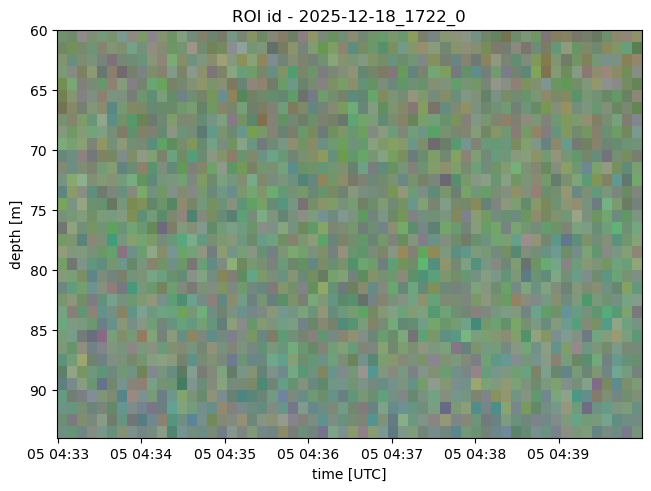

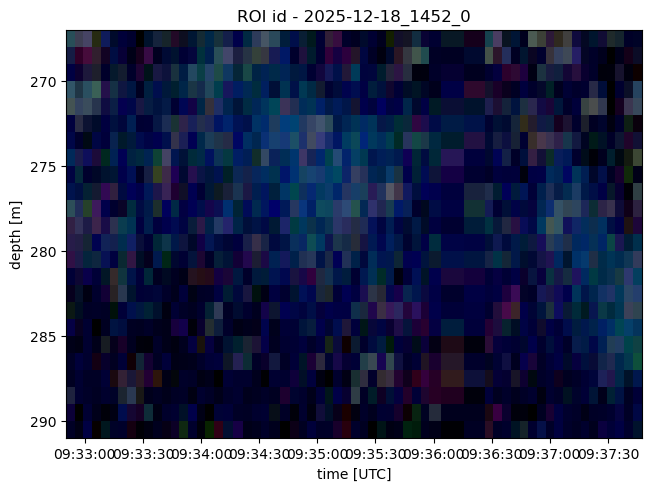

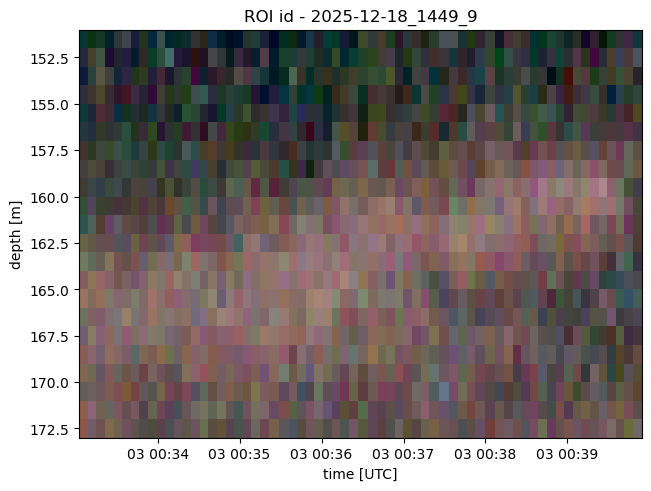

In [410]:
import matplotlib.pyplot as plt

def plot_roi(row,sv, padding=0, vmin=-90, vmax=-50):
    fig, ax = plt.subplots(layout='constrained')

    # select Sv data
    t0, t1 = row["t_min"], row["t_max"]
    z0, z1 = row["z_min"], row["z_max"]

    sv_sub = sv.isel(time=slice(t0-padding, t1+padding), depth=slice(z0-padding, z1+padding))
    time, depth = sv_sub.time, sv_sub.depth

    # plot the RGB echogram
    sv_array = sv_sub.values[:3, :, :].transpose(2, 1, 0)
    img = np.clip((sv_array - vmin)/(vmax-vmin), 0, 1)
    ax.pcolormesh(time, depth, img)

    # plot the limits of polygon (usefull when not rectangle)

    # refine plot
    ax.invert_yaxis()
    ax.set_xlabel('time [UTC]')
    ax.set_ylabel('depth [m]')
    ax.set_title(f"ROI id - {row['id']}")

    plt.show()

for i in range(3):
    plot_roi(roi_df.iloc[i], sv, padding=5)

In [ ]:

def print_roi_data(roi_data):
    print(roi_data['imagePath'])
    for shp in roi_data['shapes']:
        print(f"\tShape label:\t{shp['label']}")
        print(f"\tIs a rectangle:\t{shp['shape_type']=='rectangle'}")
        print(f"\tShape point:\t{shp['points']}")
